In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

# Hands-on Activity 22.4: Multivariate Gaussian Process Regression

## Objectives

+ Perform multivariate Gaussian process regression with automatic relevance determination.

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\E}{\mathbf{E}}
$$

## Multivariate Gaussian Process Regression

When we say "multivariate" here we refer to many function inputs, not outputs.
This just means that the input of the function we are interested in learning is a vector $\mathbf{x}$ in $\mathbb{R}^D$.
In that regard, nothing really changes compared to one-input GPR.
The formulas are exactly the same.
However, in higher dimensional settings one must pay attention to the selection of the covariance function.

Let's demonstrate this using an example.
Here is an analytical function, known as the Branin-Hoo function:
$$
f(\mathbf{x}) = f(x_1,x_2) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right]
$$
Here $\mathbf{x} = (x_1, x_2)$ and it takes values in $[0,1]^2$.
We will use this function to generate some synthetic data.
Let's superimpose the synthetic data on a contour of this function.

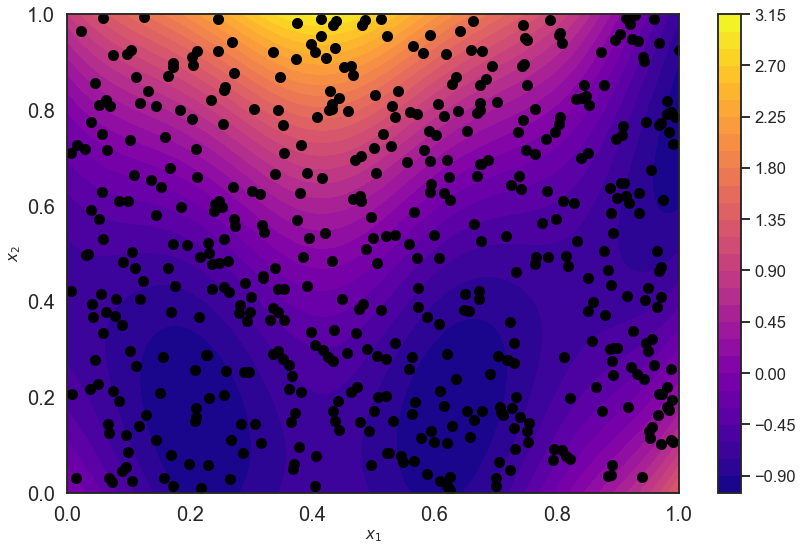

In [21]:
# Define the function
def f_branin(x):
    """
    Input must be 2D array of size N x 2.
    """
    return 1.0 / 51.95 * ((15.0 * x[:, 1] - 5.1 * (15.0 * x[:, 0]) ** 2 / 4.0 / np.pi ** 2 + 
                          75.0 * x[:, 0] / np.pi - 6.0) ** 2
                         + (10.0 - 10.0 / 8.0 / np.pi) * np.cos(15.0 * x[:, 0]) - 44.81)

# Generate synthetic data
N = 500
Xdata = np.random.rand(N, 2)
sigma = 0.01
Ydata = f_branin(Xdata)[:, None] + sigma * np.random.randn(N, 1)

# Plot the contour and the observations
fig = plt.figure( figsize=(12, 8) )
ax = plt.subplot(111)
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
_Xs = np.vstack([X1.flatten(), X2.flatten()]).T
Y = f_branin(_Xs).reshape((100, 100))

c = ax.contourf(X1, X2, Y, 30, cmap='plasma')
plt.colorbar(c)
ax.plot(Xdata[:, 0], Xdata[:, 1], 'o', color='black',  markersize=10)
ax.tick_params(labelsize=20)

ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)

fig.tight_layout()

We will be using a the squared exponential covariance function for a regression along with a zero mean.
So our prior GP is:
$$
f(\cdot)\sim\operatorname{GP}(0, k(\cdot,\cdot)),
$$
with
$$
k(\mathbf{x}, \mathbf{x}') = s^2\exp\left(-\frac{(x_1-x_1')^2}{2\ell_1^2}-\frac{(x_2-x_2')^2}{2\ell_2^2}\right).
$$
The first, situation we are going to examin is when the lengthscales are the same:
$$
\ell_1 = \ell_2.
$$
This is what you get by default from ``GPy``:

In [22]:
import GPy
k = GPy.kern.RBF(2) # The 2 here is for the dimensionality of the input space
gp = GPy.models.GPRegression(Xdata, Ydata, k)
print(gp)


Name : GP regression
Objective : 528.3230736377817
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [23]:
# perform the optimization 
gp.optimize(messages=True);

In [24]:
# print out the model details 
print(gp)


Name : GP regression
Objective : -1365.7102078756907
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |      2.061676548202336  |      +ve      |        
  rbf.lengthscale          |    0.24609563525713318  |      +ve      |        
  Gaussian_noise.variance  |  9.206440970611153e-05  |      +ve      |        


In [25]:
# check the lengthscale 
print(gp.kern.lengthscale)

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.24609564  |      +ve      |        


In [26]:
# Make predictions
Ypred_flat, Yvar_flat = gp.predict( _Xs )

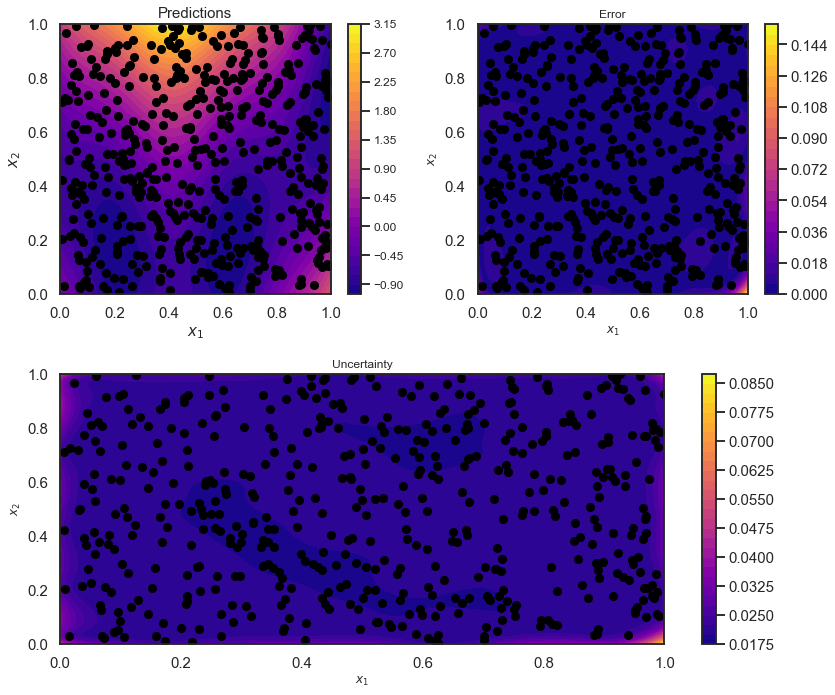

In [27]:
# start a new figure
fig = plt.figure( figsize=(12, 10) )

#plot the contour of the predictions (Compare to contour of true values above)
ax = plt.subplot(221)
ax.tick_params(axis='both', labelsize=15)
Ypred = Ypred_flat.reshape( (100, 100) )
im = ax.contourf(X1, X2, Ypred, 30, cmap='plasma')
c = plt.colorbar(im, ax=ax)
c.ax.tick_params(labelsize=12)
ax.plot(Xdata[:, 0], Xdata[:, 1], 'o', color='black', markersize=8)
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
ax.set_title('Predictions', fontsize=15)

# Let's also plot the contour of the error
ax = plt.subplot(222)
ax.tick_params(axis='both', labelsize=15)
E = np.abs(Y - Ypred)
ax.plot(Xdata[:, 0], Xdata[:, 1], 'o', color='black', markersize=8)
im = ax.contourf(X1, X2, E, 30, cmap='plasma')
c = plt.colorbar(im, ax=ax)
c.ax.tick_params(labelsize=15)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)
ax.set_title('Error', fontsize=12)

# And let's compare the error plot to 2 x the predictive standard deviation
ax = plt.subplot(212)
ax.tick_params(axis='both', labelsize=15)

im = ax.contourf(X1, X2, 2.0 * np.sqrt(Yvar_flat.reshape(X1.shape)), 30, cmap='plasma')
ax.set_title('Uncertainty', fontsize=12)
c = plt.colorbar(im, ax=ax)
c.ax.tick_params(labelsize=15)

ax.plot(Xdata[:, 0], Xdata[:, 1], 'o', color='black', markersize=8)
ax.set_xlabel('$x_1$', fontsize=12)
ax.set_ylabel('$x_2$', fontsize=12)

fig.tight_layout()

Let's get some test data and make some predictions.

0.5438198194634477


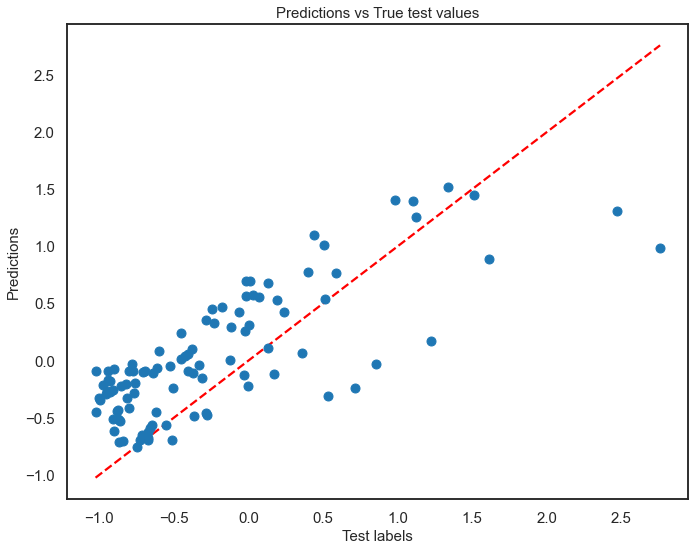

In [9]:
from sklearn.metrics import mean_squared_error

Ntest = 100
Xtest = np.random.rand(Ntest, 2)
Ytest = f_branin(Xtest)[:, None] 
Ytest_m, Ytest_v = gp.predict(Xtest, full_cov=False) 
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig = plt.figure(figsize = (10, 8))
ax  = plt.subplot(111)

_x = np.linspace( np.min(Ytest), np.max(Ytest), 100 )
ax.plot(_x, _x, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title('Predictions vs True test values', fontsize=15)
ax.set_xlabel('Test labels', fontsize=15)
ax.set_ylabel('Predictions', fontsize=15)
ax.tick_params( labelsize=15 )

fig.tight_layout()
print(error_m)

Now let's repeat the same analysis but allowing for a different lengthscale per input.
First, we set up and train the model:

In [10]:
k = GPy.kern.RBF(2, ARD=True) # The ARD = True is what makes GPy understand that there is
                              # one lengthscale per dimension
gp = GPy.models.GPRegression(Xdata, Ydata, k)
print(gp)


Name : GP regression
Objective : 7.615845725386993
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (2,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Note that you now cannot see what the lengthscale values are.
You need to do this to see them:

And you can train the model as usual:

In [11]:
gp.optimize( messages=True )
print(gp)
print(gp.rbf.lengthscale)


Name : GP regression
Objective : 4.088652862871289
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      2.5892990283924147  |      +ve      |        
  rbf.lengthscale          |                    (2,)  |      +ve      |        
  Gaussian_noise.variance  |  5.562684646268137e-309  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.41586430  |      +ve      |        
  [1]    |                  4516.20754459  |      +ve      |        


So, you see that the lengthscale assigned to $x_1$ is slightly smaller than the lengthscale assigned to $x_2$. This means that the first input is slightly more important than the second input.
This is the automatic relevance determination (ARD) in action.

Now let's try to make some predictions with the ARD version of the GP regression model.

1.3019546195606668


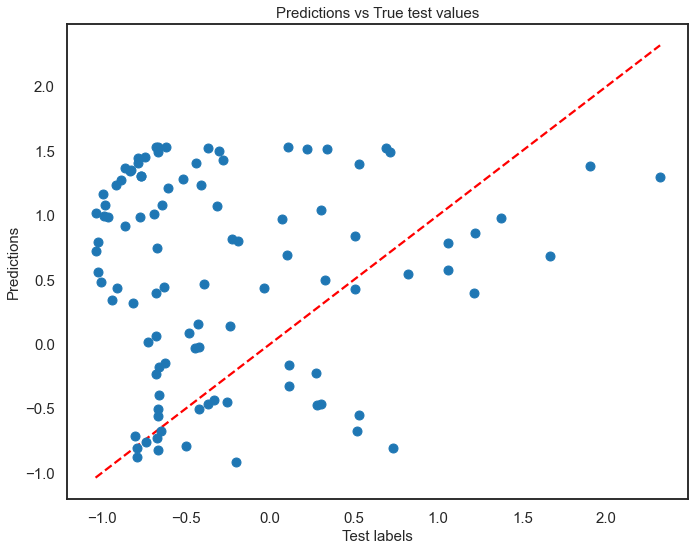

In [12]:
Ntest = 100
Xtest = np.random.rand(Ntest, 2)
Ytest = f_branin(Xtest)[:, None] 
Ytest_m, Ytest_v = gp.predict(Xtest, full_cov=False) 
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig = plt.figure(figsize = (10, 8))
ax  = plt.subplot(111)

_x = np.linspace( np.min(Ytest), np.max(Ytest), 100 )
ax.plot(_x, _x, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title('Predictions vs True test values', fontsize=15)
ax.set_xlabel('Test labels', fontsize=15)
ax.set_ylabel('Predictions', fontsize=15)
ax.tick_params( labelsize=15 )

fig.tight_layout()
print(error_m)

Let's add a third dimension to the Branin function, $x_3$, such that $f$ has a weak linear dependence on $x_3$. 

The added term is highlighted in blue.

$$
f(\mathbf{x}) = f(x_1,x_2, x_3) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right] + \color{blue}{0.1 x_3}.
$$

In [13]:
# Define the function
def f_branin_1(x):
    """
    Input must be 2D array of size N x 2.
    """
    return (1.0 / 51.95 * ((15.0 * x[:, 1] - 5.1 * (15.0 * x[:, 0]) ** 2 / 4.0 / np.pi ** 2 + 
                          75.0 * x[:, 0] / np.pi - 6.0) ** 2
                         + (10.0 - 10.0 / 8.0 / np.pi) * np.cos(15.0 * x[:, 0]) - 44.81)) + (0.1*x[:, 2])

Let's generate some synthetic data and train a GP model with ARD. Let's see if we can discover the weak dependence of $f$ on the newly added 3rd dimension. 

In [14]:
# Generate synthetic data
N    = 40
ndim = 3
Xdata = np.random.rand(N, ndim)

# We will also be adding a little bit of noise to the observations
sigma = 0.01
Ydata = f_branin_1(Xdata)[:, None] + sigma * np.random.randn(N, 1)

k = GPy.kern.RBF(ndim, ARD=True) 
gp = GPy.models.GPRegression(Xdata, Ydata, k)
print(gp)


Name : GP regression
Objective : 46.290587032865254
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (3,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [15]:
# train the GP
gp.optimize(messages=True); # No messages shown here
print(gp.rbf.lengthscale)

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.26466008  |      +ve      |        
  [1]    |                     1.18212391  |      +ve      |        
  [2]    |                    48.47215420  |      +ve      |        


Notice from the results above that the lengthscale in the 3rd dimension is very large relative to the lengthscales along the 1st and 2nd dimensions. 
This means that our trained GP model depends very weakly on $x_3$. Clearly, we are able to capture the weak dependence of $f$ on $x_3$. 

Let's make some predictions on the test data:

0.02798837565772872


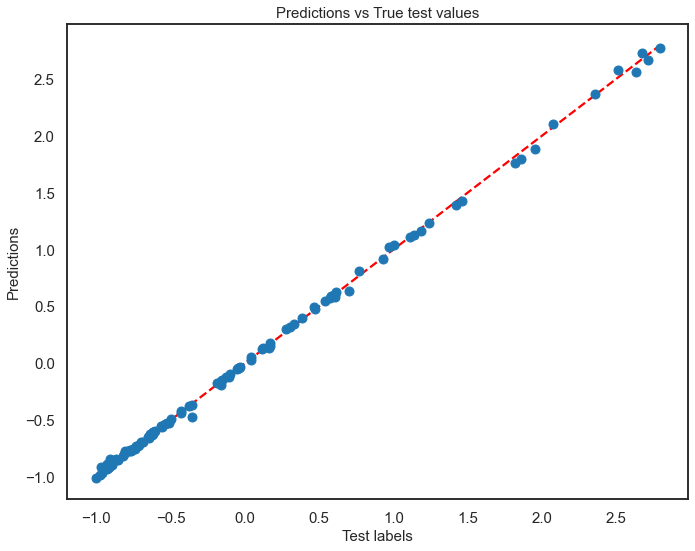

In [16]:
Ntest = 100
Xtest = np.random.rand(Ntest, ndim)
Ytest = f_branin_1(Xtest)[:, None] 
Ytest_m, Ytest_v = gp.predict(Xtest, full_cov=False) 
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig = plt.figure(figsize = (10, 8))
ax  = plt.subplot(111)

_x = np.linspace( np.min(Ytest), np.max(Ytest), 100 )
ax.plot(_x, _x, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title('Predictions vs True test values', fontsize=15)
ax.set_xlabel('Test labels', fontsize=15)
ax.set_ylabel('Predictions', fontsize=15)
ax.tick_params( labelsize=15 )

fig.tight_layout()
print(error_m)

Now let's add a fourth dimension to the Branin function, $x_4$, such that $f(x_1, x_2, x_3, x_4) = f(x_1, x_2, x_3)$, i.e., $f$ does not actually depend on $x_4$. 


$$
f(\mathbf{x}) = f(x_1,x_2, x_3, x_4) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right] + \color{blue}{0.1 x_3}.
$$

In [17]:
# define the function
def f_branin_2(x):
    assert x.shape[1] == 4, 'The input should be 4 dimensional.'
    return f_branin_1(x[:, :3])

In [18]:
# Generate synthetic data
N    = 40
ndim = 4
Xdata = np.random.rand(N, ndim)

# We will also be adding a little bit of noise to the observations
sigma = 0.01
Ydata = f_branin_2(Xdata)[:, None] + sigma * np.random.randn(N, 1)

k = GPy.kern.RBF(ndim, ARD=True) 
gp = GPy.models.GPRegression(Xdata, Ydata, k)
print(gp)


Name : GP regression
Objective : 49.556485682092315
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (4,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


In [19]:
# train the GP
gp.optimize(messages=True); # No messages shown here
print(gp.rbf.lengthscale)

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.26609277  |      +ve      |        
  [1]    |                     1.33391834  |      +ve      |        
  [2]    |                    34.68816713  |      +ve      |        
  [3]    |                   107.09459094  |      +ve      |        


Notice that $\ell_4$ is much larger than $\ell_3$, which itself is much larger than $\ell_1$ and $\ell_2$. 
The ARD training procedure discovers that the dependence of the function $f$ is very weak in the input $x_4$.

Now let's make some predictions and compare it to the test observations.

0.022546857826940814


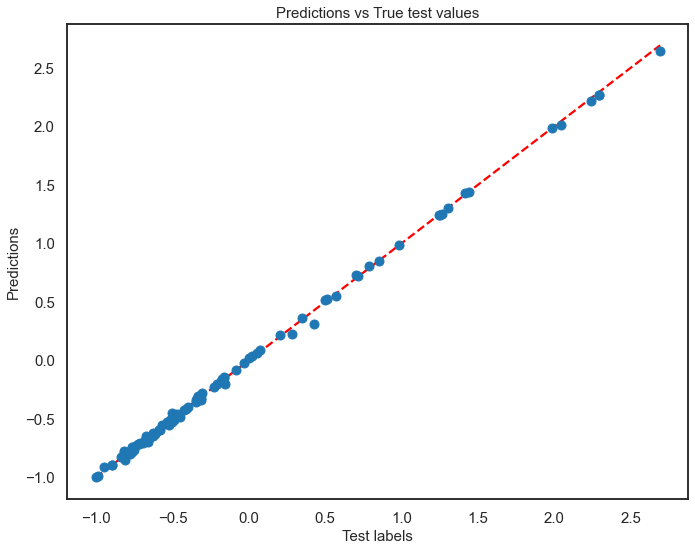

In [20]:
Ntest = 100
Xtest = np.random.rand(Ntest, ndim)
Ytest = f_branin_2(Xtest)[:, None] 
Ytest_m, Ytest_v = gp.predict(Xtest, full_cov=False) 
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig = plt.figure(figsize = (10, 8))
ax  = plt.subplot(111)

_x = np.linspace( np.min(Ytest), np.max(Ytest), 100 )
ax.plot(_x, _x, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title('Predictions vs True test values', fontsize=15)
ax.set_xlabel('Test labels', fontsize=15)
ax.set_ylabel('Predictions', fontsize=15)
ax.tick_params( labelsize=15 )

fig.tight_layout()
print(error_m)

#### Questions:
For the very last example (4D):
+ Add code cells above that compute the standarized errors and does the quantile-quantile plots.
+ Experiment with very small number of samples $N$. What happens?
+ Experiment with very large number of samples, say $N = 500$. What happens?